# Benchmarking

In [ ]:
from Utility import generate_matrix,generate_qram_circuit,generate_phase_estimation_circuit,eigenvectors_benchmarking,eigenvectors_reconstruction,state_vector_tomography,thetas_computation

# Matrix generation

In [13]:
eigenvalues=[2,1]
input_matrix=generate_matrix(matrix_dimension=2,eigenvalues_list=eigenvalues,replicate_paper=False)

Matrix:
 [[ 1.68 -0.47]
 [-0.47  1.32]]

eigenvalue: 1 - eigenvector: [0.565 0.825]
eigenvalue: 2 - eigenvector: [ 0.825 -0.565]


# Create circuit for matrix encoding 

In [14]:
thetas, all_combinations = thetas_computation(input_matrix)
matrix_circuit = generate_qram_circuit(input_matrix,thetas, all_combinations)
matrix_circuit.draw()

┌────────────┐┌───┐               ┌───┐              
q_0: ┤ Ry(1.3527) ├┤ X ├───────■───────┤ X ├──────■───────
     └────────────┘└───┘┌──────┴──────┐└───┘┌─────┴──────┐
q_1: ───────────────────┤ Ry(0.54147) ├─────┤ Ry(2.4622) ├
                        └─────────────┘     └────────────┘

# Perform Phase estimation and tomography 

In [15]:
pe_circuit=generate_phase_estimation_circuit(resolution=2,input_matrix=input_matrix)

In [16]:
statevector_dictionary=state_vector_tomography(matrix_circuit=matrix_circuit,pe=pe_circuit,n_shots=50000)

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


# Reconstruct eigenvectors

In [17]:
eigenvectors=eigenvectors_reconstruction(statevector_dictionary=statevector_dictionary,resolution=2,input_matrix=input_matrix)

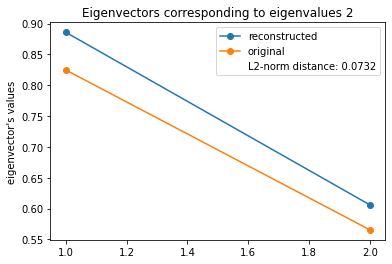

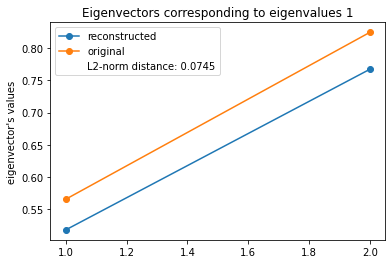

In [18]:
eigenvectors_benchmarking(originals=input_matrix,reconstructed_eigenvectors=eigenvectors)

# Using QPCA class

In [1]:
from UtilityClass import QPCA, check_measure
import numpy as np
import matplotlib.pyplot as plt

In [2]:
qpca=QPCA(resolution=2, seed=1235)

In [3]:
eigenvalues=[2,1]
input_matrix=qpca.generate_matrix(matrix_dimension=2,eigenvalues_list=eigenvalues, replicate_paper=False)
input_matrix

Matrix:
 [[1.63 0.48]
 [0.48 1.37]]

eigenvalue: 1 - eigenvector: [-0.605  0.796]
eigenvalue: 2 - eigenvector: [0.796 0.605]


array([[1.63379432, 0.48176662],
       [0.48176662, 1.36620568]])

In [4]:
thetas, all_combinations=qpca.thetas_computation()
qram_circuit=qpca.generate_qram_circuit()
qram_circuit.draw()

┌────────────┐┌───┐              ┌───┐              
q_0: ┤ Ry(1.4095) ├┤ X ├──────■───────┤ X ├──────■───────
     └────────────┘└───┘┌─────┴──────┐└───┘┌─────┴──────┐
q_1: ───────────────────┤ Ry(0.5735) ├─────┤ Ry(2.4636) ├
                        └────────────┘     └────────────┘

In [5]:
pe_circuit=qpca.generate_phase_estimation_circuit()
pe_circuit.draw()

┌─────┐
eval_0: ┤0    ├
        │     │
eval_1: ┤1 PE ├
        │     │
     q: ┤2    ├
        └─────┘

In [29]:
'''reconstructed_statevector=qpca.state_vector_tomography(n_shots=500)
reconstructed_statevector'''

{'0000': 0.0,
 '0001': 0.0,
 '0010': 0.0,
 '0011': 0.0,
 '0100': 0.0,
 '0101': 0.0,
 '0110': 0.0,
 '0111': 0.0,
 '1000': 0.0,
 '1001': -1.0,
 '1010': 0.0,
 '1011': 0.0,
 '1100': 0.0,
 '1101': 0.0,
 '1110': 0.0,
 '1111': 0.0}

# 1st benchmark

We see how the l2 distance between the reconstructed vector and the original one decreases, when we increase the number of shots of the tomography

In [6]:
measure_indexes = np.geomspace(1, 50000, num=6, dtype=np.int64)
measure_indexes = check_measure(measure_indexes, faster_measure_increment=1000)
measure_indexes

array([    1,     8,    75,   659,  5743, 50000])

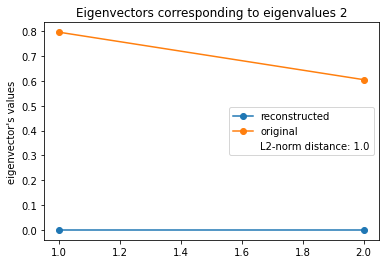

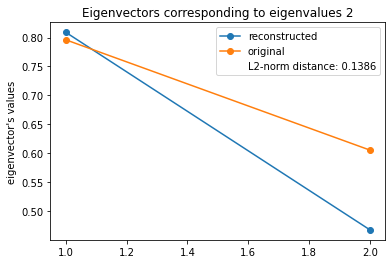

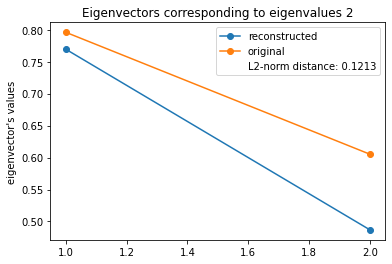

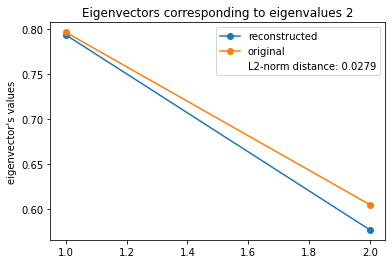

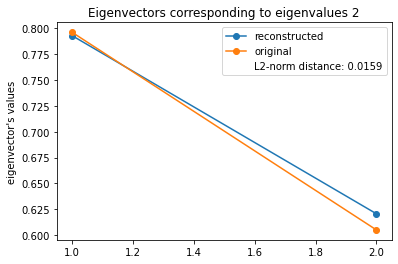

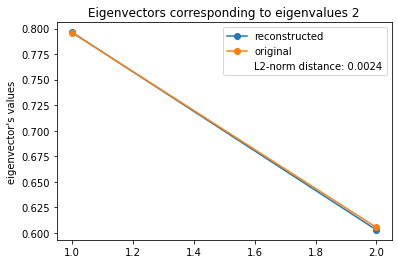

In [9]:
l2_list=[]
for s in measure_indexes:
    reconstructed_statevector=qpca.state_vector_tomography(n_shots=s)
    reconstructed_eigenvectors=qpca.eigenvectors_reconstruction()
    qpca.eigenvectors_benchmarking()

# 2nd benchmark

We see how the l2 error decreases at the increase of the number of shots in the tomography (similar to the 1st one)

In [14]:
l2_list=[]
for s in measure_indexes:
    reconstructed_statevector=qpca.state_vector_tomography(n_shots=s)
    reconstructed_eigenvectors=qpca.eigenvectors_reconstruction()
    l2_error=qpca.l2_norm_benchmark()
    l2_list.append(l2_error[0])
    #print(l2_error)
    
eigenvalue=np.unique([l[0] for l in l2_list])
l2_errors=[l[1] for l in l2_list]

eigenvalue,l2_errors    

(array([2]), [1.0, 0.2599, 0.0355, 0.0208, 0.0068, 0.0009])

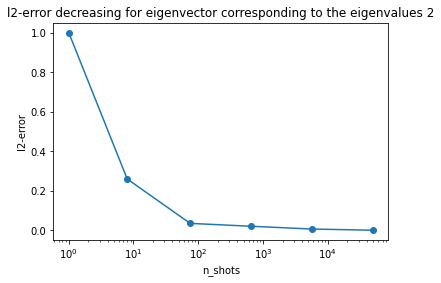

In [15]:
plt.plot(measure_indexes,l2_errors,'-o')
plt.xticks(measure_indexes)
plt.xscale('log')
plt.xlabel('n_shots')
plt.ylabel('l2-error')
plt.title('l2-error decreasing for eigenvector corresponding to the eigenvalues {}'.format(eigenvalue[0]))
plt.show()